#  Сегментация изображений

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation/data
* https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
* https://amaarora.github.io/posts/2020-09-13-unet.html
* https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
* https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8
* https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
* https://huggingface.co/docs/transformers/model_doc/segformer
* https://www.kaggle.com/code/damianpanek/segformerb0-people-clothing-segmentation

## Задачи для совместного разбора

1\. Обсудите постановку задачи сегментации изображений.

2\. Рассмотрите пример работы слоя `ConvTranspose2d`.

In [ ]:
import os
import random
from pathlib import Path
from typing import Callable, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torch.nn.functional as F
from torchvision import transforms


device = torch.device('cuda' if torch.cuda.is_available() else (
    'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else 'cpu'
))
print('Используемое устройство:', DEVICE)

DATA_ROOT = Path('Clothes')  # корень датасета с подкаталогами Train/Test


import torchvision.transforms as T


import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os


#from transformers import SegformerForSemanticSegmentation, SegformerConfig

from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


from transformers import SegformerForSemanticSegmentation


Используемое устройство: mps


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Опишите датасет `ClothesSegmentationDataset`. Реализуйте `__getitem__` таким образом, чтобы он возвращал два элемента: тензор с изображением и тензор с маской. Маска должна быть представлена трехмерным тензором целых чисел. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений и масок. Создайте объект датасета и выведите на экран форму и типы одного изображения и его маски.

- [ ] Проверено на семинаре

In [ ]:
class ClothesSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None, image_type='png', img_size=(128, 128)):
        """
        Args:
            root_dir (string): Корневая директория датасета (папка Clothes)
            transform (callable, optional): Трансформации для изображений
            target_transform (callable, optional): Трансформации для масок
            image_type (string): Тип изображений ('png' или 'jpeg')
            img_size (tuple): Размер для ресайза изображений и масок
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_type = image_type
        self.img_size = img_size
        
        if image_type.lower() == 'png':
            self.images_dir = os.path.join(root_dir, 'png_images')
            self.masks_dir = os.path.join(root_dir, 'png_masks')
        else:
            self.images_dir = os.path.join(root_dir, 'jpeg_images')
            self.masks_dir = os.path.join(root_dir, 'jpeg_masks')
        
        labels_path = os.path.join(root_dir, 'labels.csv')
        self.labels_df = pd.read_csv(labels_path)
        
        self.image_files = [f for f in os.listdir(self.images_dir) 
                           if f.endswith(('.png', '.jpg', '.jpeg'))]
        
        self.image_files.sort()
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        
        img_path = os.path.join(self.images_dir, img_name)
        
        mask_name = 'seg'+img_name[3:]
        mask_path = os.path.join(self.masks_dir, mask_name)
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        
        image = image.resize(self.img_size, Image.BILINEAR)
        mask = mask.resize(self.img_size, Image.NEAREST)
        
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        
        if self.target_transform:
            mask = self.target_transform(mask)
        else:
            mask = torch.from_numpy(np.array(mask)).long()
            
            if mask.dim() == 2:
                mask = mask.unsqueeze(0)  # (H, W) -> (1, H, W)
        
        return image, mask.squeeze(0)  # Возвращаем маску в формате (H, W)

<p class="task" id="2"></p>

2\. Напишите функцию `show_image_with_mask`, которая выводит рядом два изображения: фотографию и маску. Продемонстрируйте работу функции, взяв один пример из созданного датасета.

- [ ] Проверено на семинаре

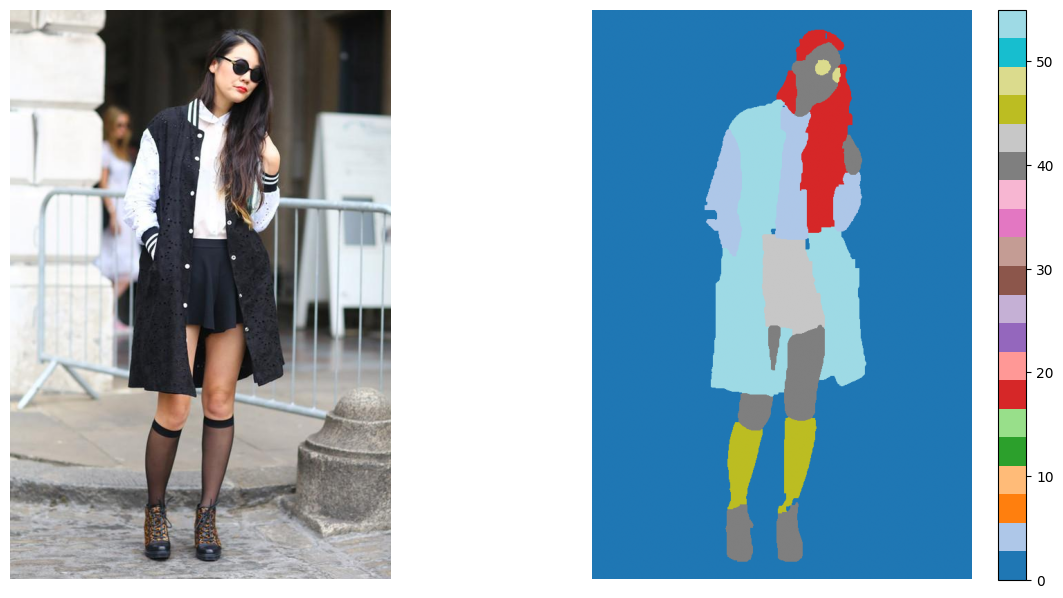

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms

def show_image_with_mask(image, mask, figsize=(12, 6)):
    """
    Визуализирует изображение и маску сегментации рядом
    
    Args:
        image: тензор изображения формата [C, H, W] или PIL Image
        mask: тензор маски формата [H, W, C] или [H, W]
        figsize: размер фигуры
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    if isinstance(image, torch.Tensor):
        # Для тензора: конвертируем из [C, H, W] в [H, W, C] и нормализуем
        image_np = image.permute(1, 2, 0).numpy()
        # Если изображение было нормализовано, денормализуем для отображения
        if image_np.min() < 0 or image_np.max() > 1:
            image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    else:
        # Для PIL Image просто конвертируем в numpy
        image_np = np.array(image)
    
    if isinstance(mask, torch.Tensor):
        mask_np = mask.squeeze().numpy()  # Убираем лишние размерности
    else:
        mask_np = np.array(mask).squeeze()
    
    ax1.imshow(image_np)
    ax1.axis('off')
    
    im = ax2.imshow(mask_np, cmap='tab20')  # Используем colormap с множеством цветов
    ax2.axis('off')
    
    plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    

if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    dataset = ClothesSegmentationDataset(
        root_dir='Clothes',
        transform=transform,
        image_type='png'
    )
    
    image, mask = dataset[0]
    
    show_image_with_mask(image, mask)
    

<p class="task" id="3"></p>

3\. Реализуйте архитектуру U-Net. Реализуйте модель таким образом, чтобы на выходе для каждого изображения получался тензор размера `n_classes x h x w`, где `n_classes` - количество уникальных значений в масках, а `h` и `w` - размер исходного изображения. Возьмите один пример из набора данных и пропустите его через сеть. Выведите форму полученного результата на экран. 

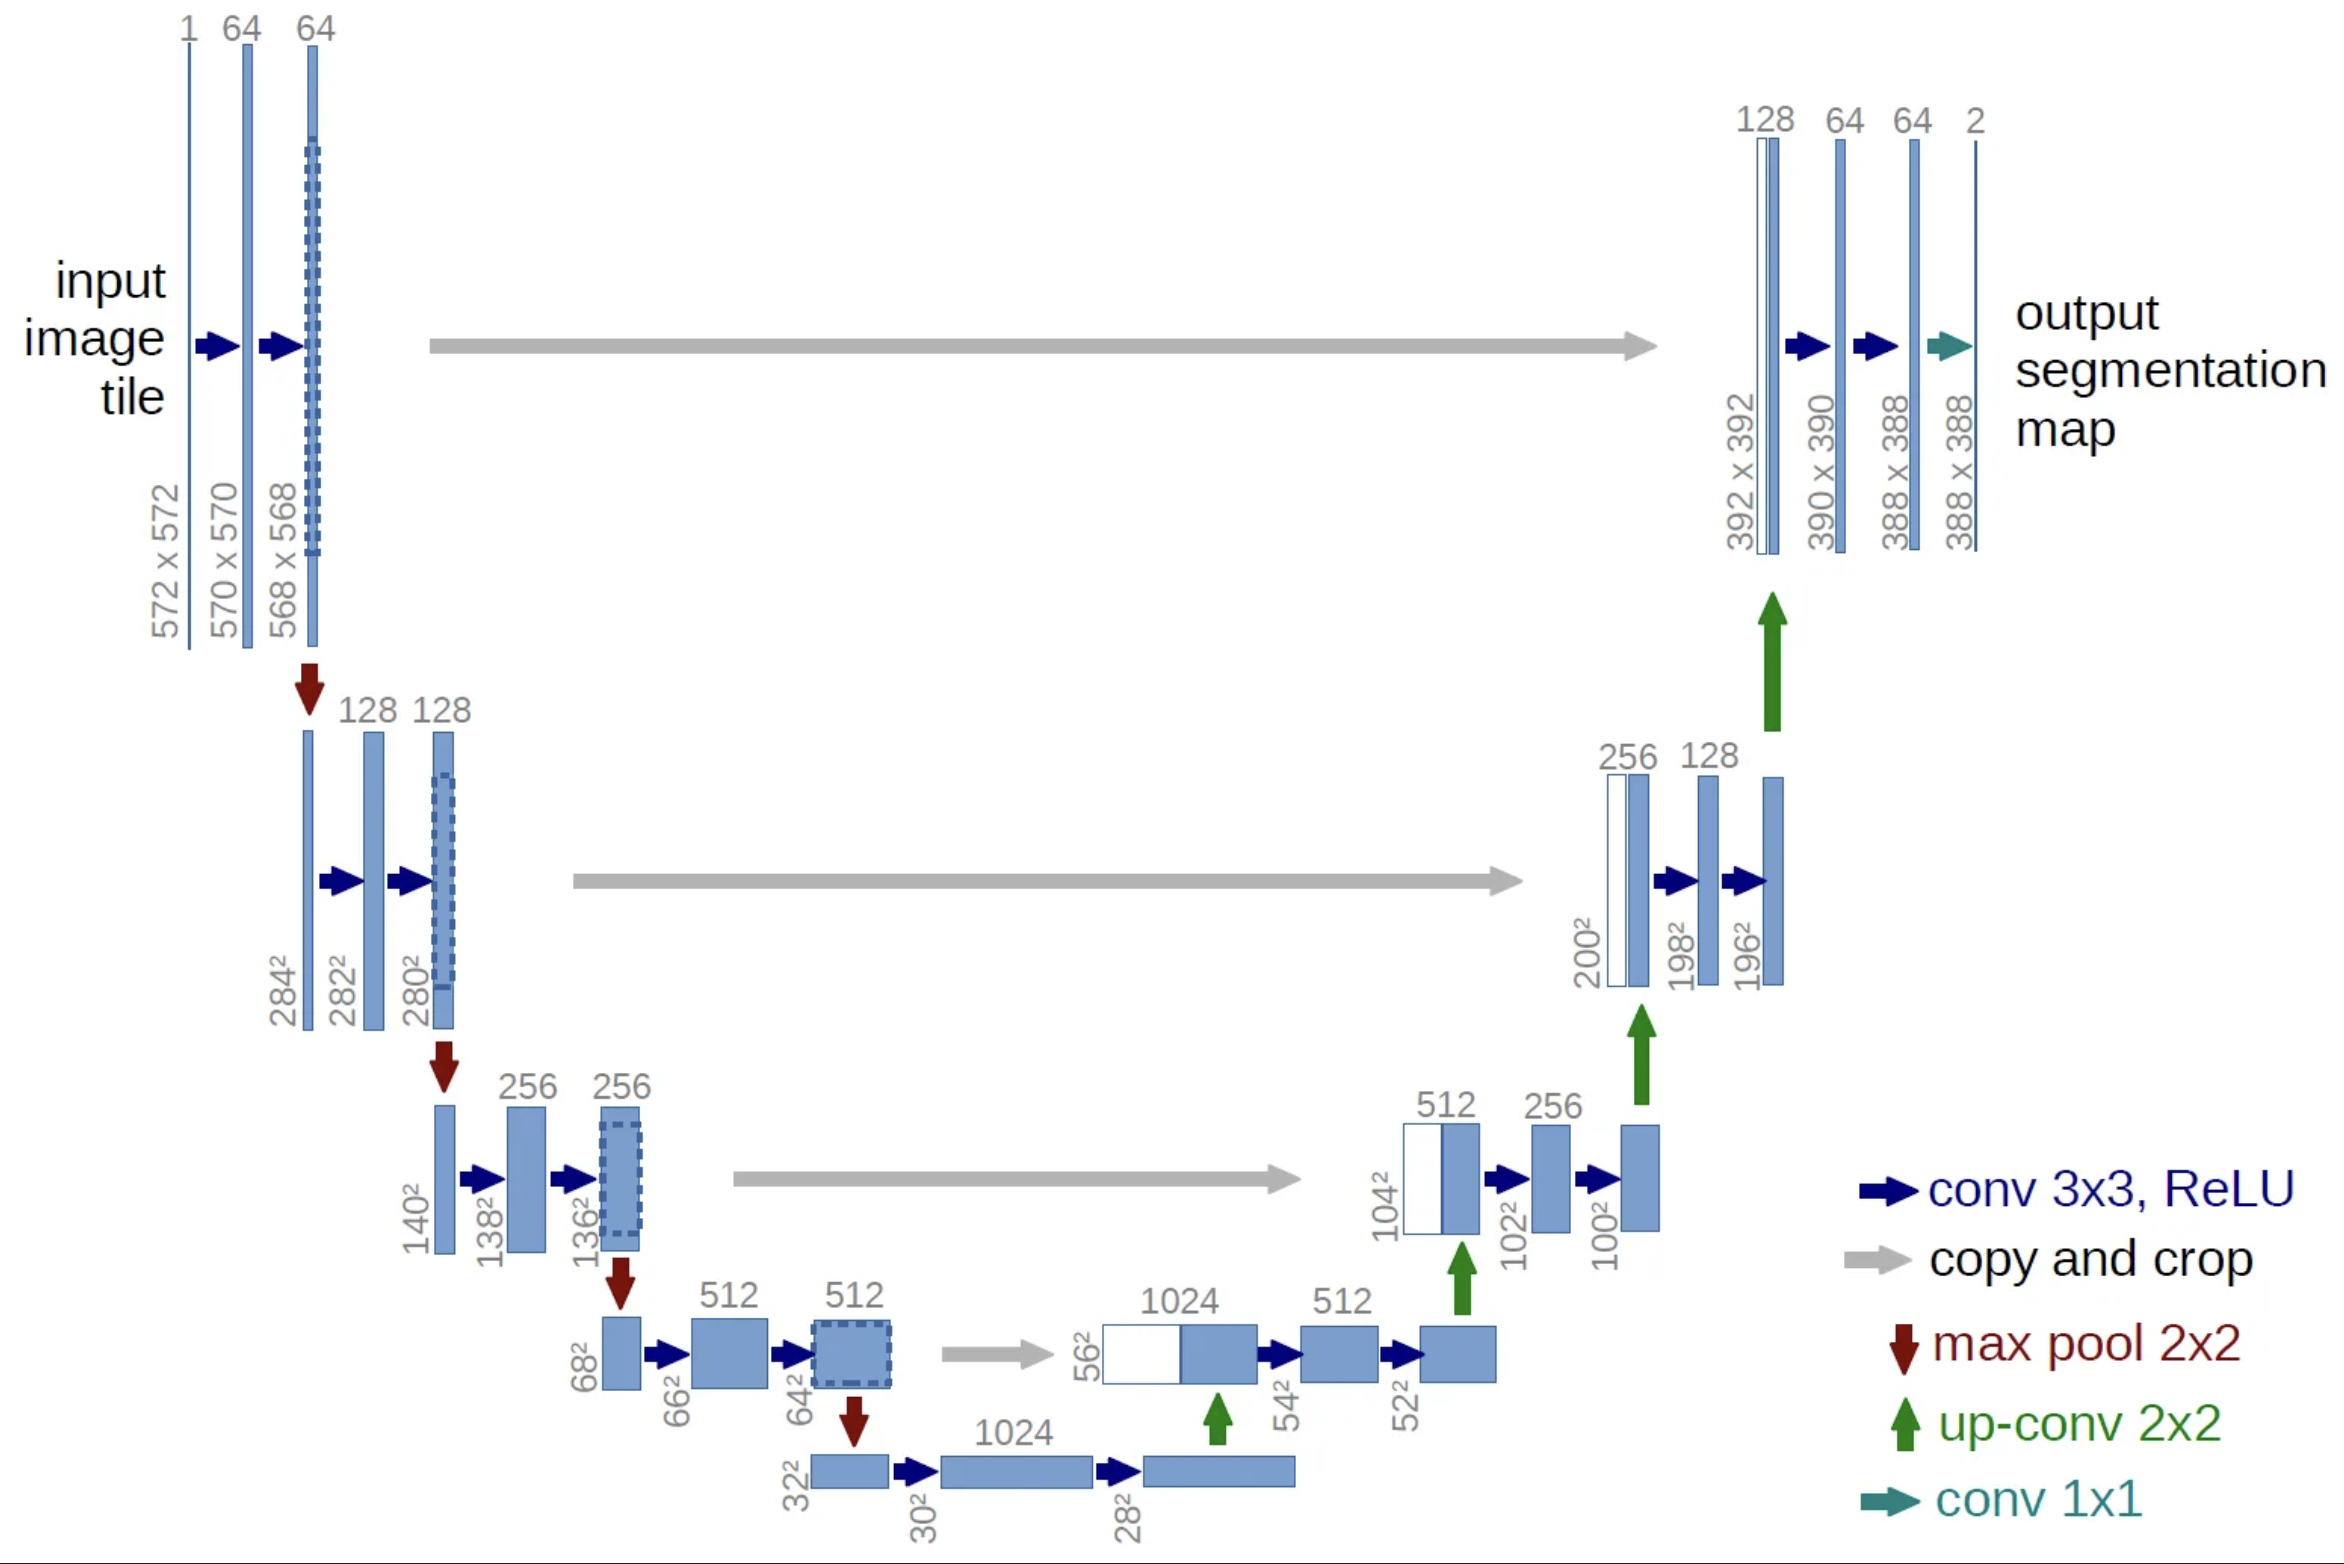
- [ ] Проверено на семинаре

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class UNet(nn.Module):
    def __init__(self, in_channels: int, num_classes: int):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottom = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        c1 = self.down1(x)
        p1 = self.pool1(c1)

        c2 = self.down2(p1)
        p2 = self.pool2(c2)

        c3 = self.down3(p2)
        p3 = self.pool3(c3)

        c4 = self.down4(p3)
        p4 = self.pool4(c4)

        cb = self.bottom(p4)

        u4 = self.up4(cb)
        u4 = torch.cat([u4, c4], dim=1)
        c4u = self.conv4(u4)

        u3 = self.up3(c4u)
        u3 = torch.cat([u3, c3], dim=1)
        c3u = self.conv3(u3)

        u2 = self.up2(c3u)
        u2 = torch.cat([u2, c2], dim=1)
        c2u = self.conv2(u2)

        u1 = self.up1(c2u)
        u1 = torch.cat([u1, c1], dim=1)
        c1u = self.conv1(u1)

        out = self.out_conv(c1u)  # (B, num_classes, H, W)
        return out

Входное изображение:
Форма: torch.Size([1, 3, 825, 550])
Диапазон значений: [0.000, 1.000]

Выход модели:
Форма: torch.Size([1, 35, 825, 550])
Диапазон значений: [-4.822, 5.548]
Количество классов: 35

Сравнение размеров:
Вход: 825 x 550
Выход: 825 x 550


<p class="task" id="4"></p>

4\.  Разбейте набор данных на обучающее и валидационное множество. Обучите модель U-Net для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Обратите внимание, что выборка является несбалансированной. При расчете функции потерь примените любую известную вам технику для работы с несбалансированными выборками. 

При создании датасета допускается использовать преобразования, уменьшающие размер изображений (для ускорения процесса обучения). 

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре



использовать кросс энтропию с инсользованием весов для каждого класса

ЗАПУСК ОБУЧЕНИЯ U-Net ДЛЯ СЕГМЕНТАЦИИ ОДЕЖДЫ
Вычисление весов классов...
Количество пикселей по классам:
Класс 0: 1258683.0 пикселей, вес: 0.0340
Класс 1:   2495.0 пикселей, вес: 17.1769
Класс 2:   9433.0 пикселей, вес: 4.5432
Класс 3:   1373.0 пикселей, вес: 31.2137
Класс 4:  12936.0 пикселей, вес: 3.3130
Класс 5:  27380.0 пикселей, вес: 1.5652
Класс 6:    792.0 пикселей, вес: 54.1115
Класс 7:   1482.0 пикселей, вес: 28.9179
Класс 8:      0.0 пикселей, вес: 1.0000 (класс отсутствует)
Класс 9:     80.0 пикселей, вес: 535.7043
Класс 10:   4991.0 пикселей, вес: 8.5867
Класс 11:      0.0 пикселей, вес: 1.0000 (класс отсутствует)
Класс 12:      0.0 пикселей, вес: 1.0000 (класс отсутствует)
Класс 13:  40555.0 пикселей, вес: 1.0567
Класс 14:  43734.0 пикселей, вес: 0.9799
Класс 15:      0.0 пикселей, вес: 1.0000 (класс отсутствует)
Класс 16:    271.0 пикселей, вес: 158.1415
Класс 17:    142.0 пикселей, вес: 301.8052
Класс 18:    236.0 пикселей, вес: 181.5947
Класс 19:  18608.0 пикселей, вес:

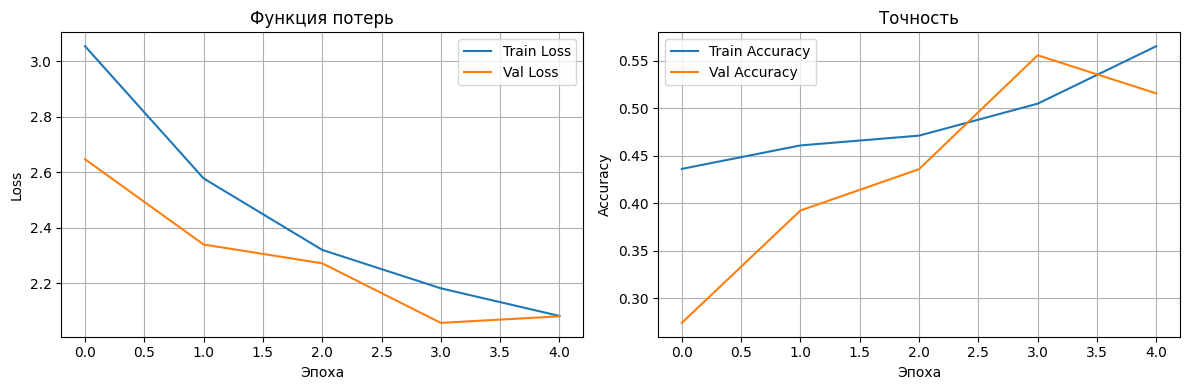

ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ


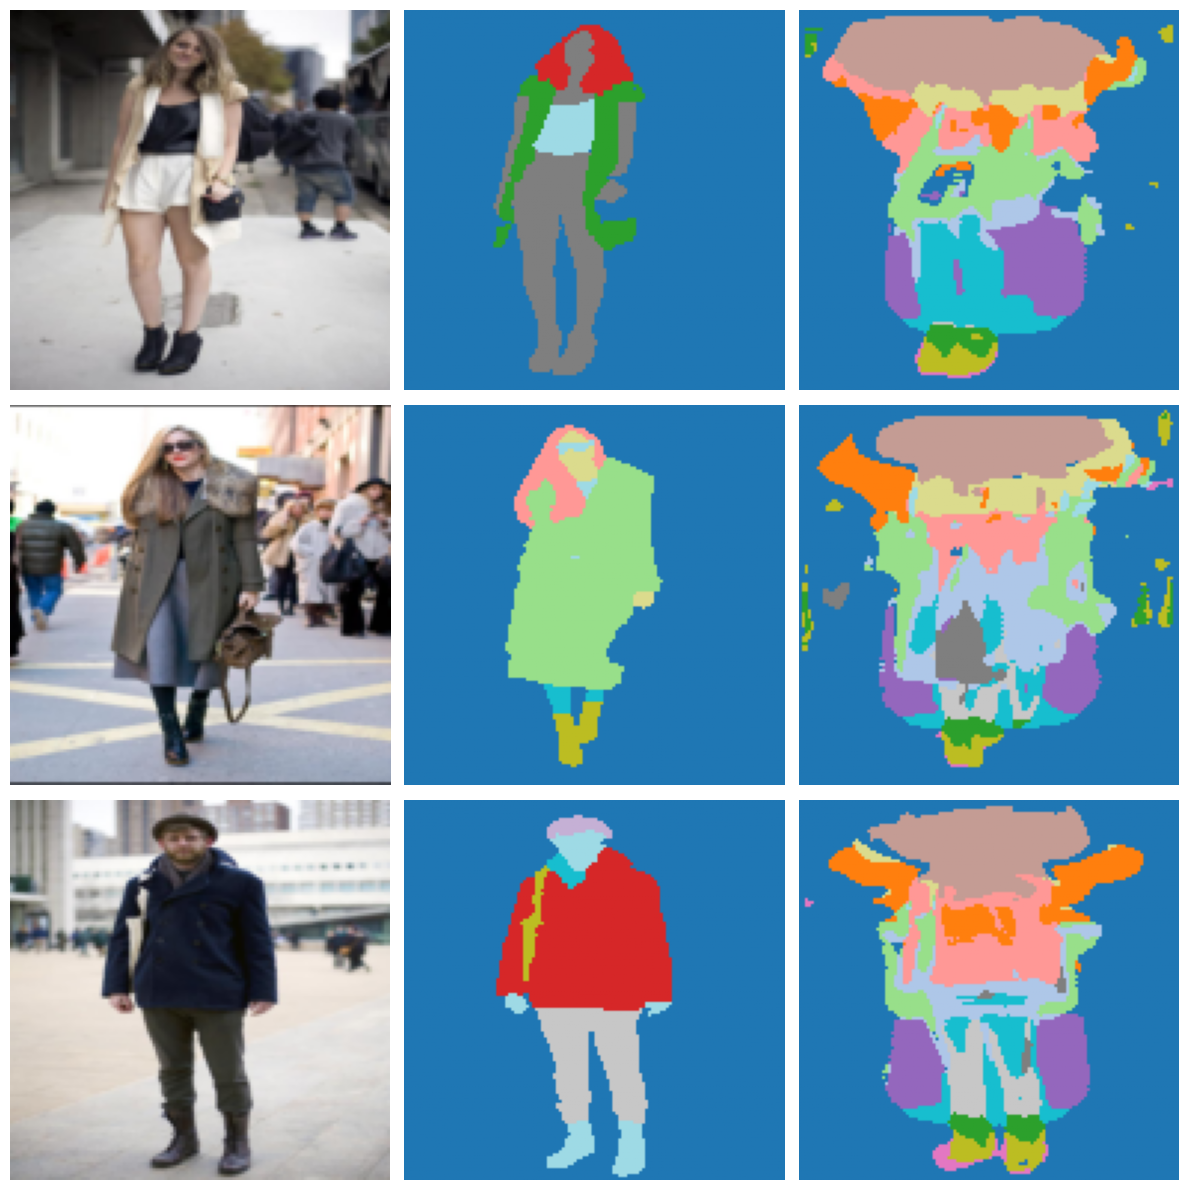

In [ ]:
def calculate_class_weights(dataset, n_classes=35):
    print("Вычисление весов классов...")
    
    class_counts = torch.zeros(n_classes)
    
    # Считаем пиксели каждого класса
    for i in range(min(100, len(dataset))):
        _, mask = dataset[i]
        for class_id in range(n_classes):
            class_counts[class_id] += (mask == class_id).sum().item()
    
    print("Количество пикселей по классам:")
    total_pixels = class_counts.sum().item()
    
    weights = torch.zeros(n_classes)
    for i in range(n_classes):
        if class_counts[i] > 0:
            weights[i] = total_pixels / (n_classes * class_counts[i])
            print(f"Класс {i}: {class_counts[i]:>8} пикселей, вес: {weights[i]:.4f}")
        else:
            weights[i] = 1.0
            print(f"Класс {i}: {class_counts[i]:>8} пикселей, вес: {weights[i]:.4f} (класс отсутствует)")
    
    weights = weights / weights.sum() * n_classes
    
    print(f"\nОбщее количество пикселей: {total_pixels}")
    return weights

def train_unet(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)      # (B, H, W)

        optimizer.zero_grad()
        logits = model(images)          # (B, C, H, W)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

        with torch.no_grad():
            preds = logits.argmax(dim=1)          # (B, H, W)
            total_correct += (preds == labels).sum().item()
            total_pixels += labels.numel()

    avg_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / total_pixels
    return avg_loss, accuracy

def evaluate_unet(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)

            total_loss += loss.item() * images.size(0)

            preds = logits.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_pixels += labels.numel()

    avg_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / total_pixels
    return avg_loss, accuracy

def train_model():
    # Параметры
    BATCH_SIZE = 4
    NUM_EPOCHS = 5
    LEARNING_RATE = 1e-3
    IMG_SIZE = (128, 128)
    N_CLASSES = 35

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    dataset = ClothesSegmentationDataset(
        root_dir='Clothes',
        transform=transform,
        image_type='png',
        img_size=IMG_SIZE
    )

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    class_weights = calculate_class_weights(dataset, N_CLASSES)
    class_weights = class_weights.to(device)

    model = UNet(in_channels=3, num_classes=N_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    print("Начало обучения UNet...")
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_unet(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_unet(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'\nЭпоха {epoch+1}/{NUM_EPOCHS}')
        print(f'Loss: Train {train_loss:.4f} | Val {val_loss:.4f}')
        print(f'Acc:  Train {train_acc:.4f} | Val {val_acc:.4f}')
        print('-' * 40)

    torch.save(model.state_dict(), 'unet_clothes_segmentation.pth')
    return model, train_losses, val_losses, train_accs, val_accs, val_dataset, device

def visualize_results(model, dataset, device, num_samples=3):
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    for i in range(num_samples):
        idx = torch.randint(0, len(dataset), (1,)).item()
        image, true_mask = dataset[idx]
        
        with torch.no_grad():
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            pred_mask = torch.argmax(output, dim=1).squeeze().cpu()

        image_np = image.permute(1, 2, 0).numpy()
        axes[i, 0].imshow(image_np)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_mask.numpy(), cmap='tab20')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_mask.numpy(), cmap='tab20')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title('Функция потерь')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Val Accuracy')
    ax2.set_title('Точность')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("ЗАПУСК ОБУЧЕНИЯ U-Net ДЛЯ СЕГМЕНТАЦИИ ОДЕЖДЫ")
    print("=" * 50)
    
    model, train_losses, val_losses, train_accs, val_accs, val_dataset, device = train_model()
    
    print("\nВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ")
    plot_training_curves(train_losses, val_losses, train_accs, val_accs)
    
    print("ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ")
    visualize_results(model, val_dataset, device, num_samples=3)

<p class="task" id="5"></p>

5\.  Обучите модуль `SegformerForSemanticSegmentation` из пакета `transformers` для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Для оптимизации используйте значение функции потерь, которое возвращает вам модель.

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

ОБУЧЕНИЕ SegFormer ДЛЯ СЕГМЕНТАЦИИ ОДЕЖДЫ
Запуск обучения с ручным вычислением loss...
Устройство: cpu
Всего примеров: 1000
Обучающих примеров: 800
Валидационных примеров: 200
Загрузка модели SegFormer...


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Начало обучения SegFormer с ручным loss...


Val Epoch 1/5: 100%|██████████| 50/50 [00:24<00:00,  2.00it/s]



Эпоха 1/5:
Loss:  Train 2.1468 | Val 1.4189
Acc:   Train 0.3641 | Val 0.4800
--------------------------------------------------


Val Epoch 2/5: 100%|██████████| 50/50 [00:25<00:00,  2.00it/s]



Эпоха 2/5:
Loss:  Train 1.0909 | Val 0.7495
Acc:   Train 0.4592 | Val 0.5037
--------------------------------------------------


Val Epoch 3/5: 100%|██████████| 50/50 [00:24<00:00,  2.02it/s]



Эпоха 3/5:
Loss:  Train 0.6440 | Val 0.5225
Acc:   Train 0.5047 | Val 0.5084
--------------------------------------------------


Val Epoch 4/5: 100%|██████████| 50/50 [00:24<00:00,  2.02it/s]



Эпоха 4/5:
Loss:  Train 0.4977 | Val 0.4532
Acc:   Train 0.5443 | Val 0.5465
--------------------------------------------------


Val Epoch 5/5: 100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


Эпоха 5/5:
Loss:  Train 0.4255 | Val 0.4299
Acc:   Train 0.5796 | Val 0.5337
--------------------------------------------------
Модель SegFormer сохранена!

ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ


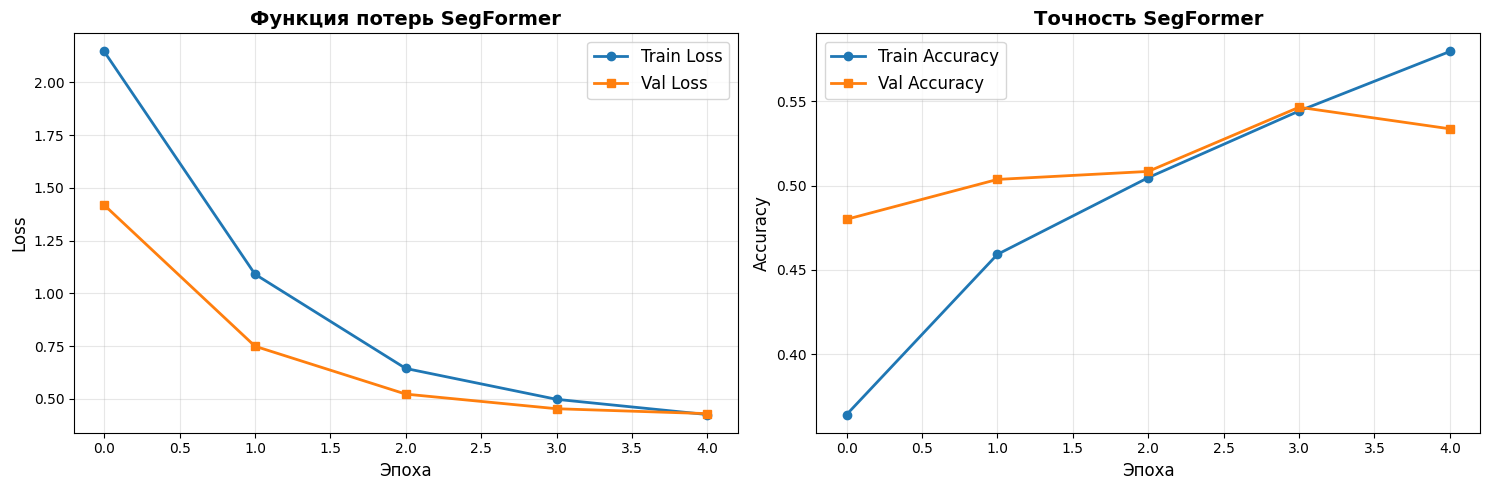


ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ


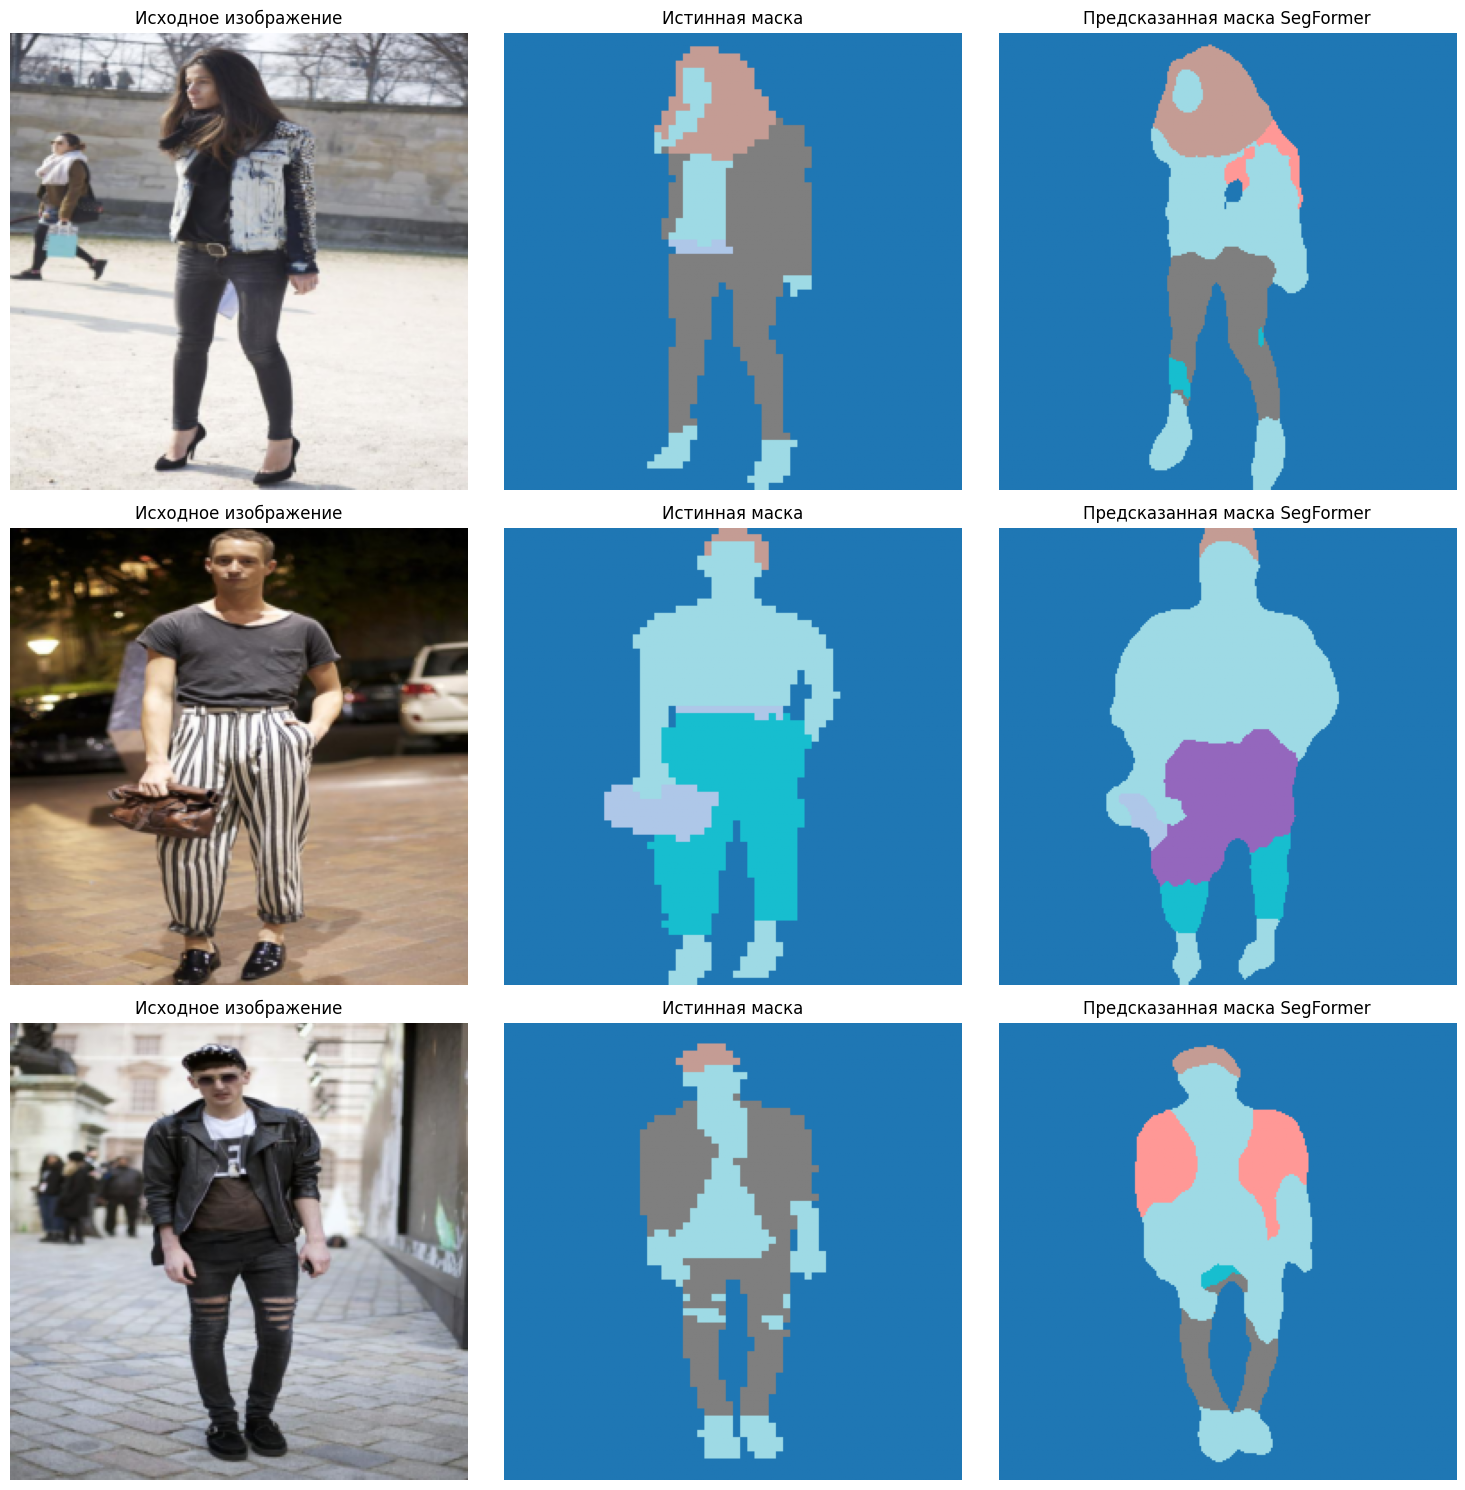

In [ ]:
class SimpleSegformerDataset(Dataset):
    def __init__(self, root_dir, image_type='png', img_size=256):
        self.root_dir = root_dir
        self.img_size = img_size
        
        if image_type == 'png':
            self.images_dir = os.path.join(root_dir, 'png_images')
            self.masks_dir = os.path.join(root_dir, 'png_masks')
        else:
            self.images_dir = os.path.join(root_dir, 'jpeg_images') 
            self.masks_dir = os.path.join(root_dir, 'jpeg_masks')
            
        self.image_files = [f for f in os.listdir(self.images_dir) if f.endswith(f'.{image_type}')]
        
        self.image_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.mask_size = img_size // 4
        self.mask_transform = transforms.Compose([
            transforms.Resize((self.mask_size, self.mask_size), interpolation=transforms.InterpolationMode.NEAREST),
        ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        mask_name = 'seg' + img_name[3:]
        mask_path = os.path.join(self.masks_dir, mask_name)
        mask = Image.open(mask_path)
        
        image = self.image_transform(image)
        mask = self.mask_transform(mask)
        mask_array = np.array(mask)
        
        mask_array = np.clip(mask_array, 0, 34)
        
        mask_tensor = torch.from_numpy(mask_array).long()
        
        return image, mask_tensor





# ==================== АЛЬТЕРНАТИВНЫЙ ПОДХОД С РУЧНЫМ LOSS ====================
def train_segformer_manual_loss():
    """Обучение с ручным вычислением loss для избежания ошибок"""
    
    # Параметры
    BATCH_SIZE = 4
    NUM_EPOCHS = 5
    LEARNING_RATE = 5e-5
    IMG_SIZE = 256
    N_CLASSES = 35
    
    device = torch.device('cpu')  # Используем CPU для максимальной стабильности
    print(f"Устройство: {device}")
    
    dataset = SimpleSegformerDataset(
        root_dir='Clothes',
        image_type='png',
        img_size=IMG_SIZE
    )
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"Всего примеров: {len(dataset)}")
    print(f"Обучающих примеров: {len(train_dataset)}")
    print(f"Валидационных примеров: {len(val_dataset)}")
    
    print("Загрузка модели SegFormer...")
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/mit-b0",
        num_labels=N_CLASSES,
        ignore_mismatched_sizes=True
    )
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    print("\nНачало обучения SegFormer с ручным loss...")
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for images, masks in tqdm(train_loader, desc=f'Train Epoch {epoch+1}/{NUM_EPOCHS}'):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(pixel_values=images)
            logits = outputs.logits
            
            loss = criterion(logits, masks)
            
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            
            with torch.no_grad():
                predicted = logits.argmax(dim=1)
                
                mask_no_bg = masks != 0
                if mask_no_bg.sum() > 0:
                    correct = ((predicted == masks) & mask_no_bg).sum().item()
                    train_correct += correct
                    train_total += mask_no_bg.sum().item()
        
        model.eval()
        epoch_val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f'Val Epoch {epoch+1}/{NUM_EPOCHS}'):
                images, masks = images.to(device), masks.to(device)
                
                outputs = model(pixel_values=images)
                logits = outputs.logits
                loss = criterion(logits, masks)
                
                epoch_val_loss += loss.item()
                
                predicted = logits.argmax(dim=1)
                
                mask_no_bg = masks != 0
                if mask_no_bg.sum() > 0:
                    correct = ((predicted == masks) & mask_no_bg).sum().item()
                    val_correct += correct
                    val_total += mask_no_bg.sum().item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_val_loss = epoch_val_loss / len(val_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0
        val_acc = val_correct / val_total if val_total > 0 else 0
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f'\nЭпоха {epoch+1}/{NUM_EPOCHS}:')
        print(f'Loss:  Train {avg_train_loss:.4f} | Val {avg_val_loss:.4f}')
        print(f'Acc:   Train {train_acc:.4f} | Val {val_acc:.4f}')
        print('-' * 50)
    
    torch.save(model.state_dict(), 'segformer_clothes_manual.pth')
    print("Модель SegFormer сохранена!")
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies, val_dataset, device


def visualize_segformer_predictions(model, dataset, device, num_samples=3):
    """Визуализация предсказаний модели SegFormer"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        idx = torch.randint(0, len(dataset), (1,)).item()
        image, true_mask = dataset[idx]
        
        with torch.no_grad():
            outputs = model(pixel_values=image.unsqueeze(0).to(device))
            logits = outputs.logits
            
            # Интерполяция к исходному размеру для визуализации
            upsampled_logits = nn.functional.interpolate(
                logits, 
                size=(256, 256),  # Исходный размер изображения
                mode="bilinear", 
                align_corners=False
            )
            pred_mask = upsampled_logits.argmax(dim=1).squeeze().cpu()
        
        image_np = image.numpy().transpose(1, 2, 0)
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image_np = np.clip(image_np, 0, 1)
        
        true_mask_upscaled = nn.functional.interpolate(
            true_mask.unsqueeze(0).unsqueeze(0).float(),
            size=(256, 256),
            mode="nearest"
        ).squeeze().long().numpy()
        
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title('Исходное изображение')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(true_mask_upscaled, cmap='tab20', vmin=0, vmax=34)
        axes[i, 1].set_title('Истинная маска')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_mask.numpy(), cmap='tab20', vmin=0, vmax=34)
        axes[i, 2].set_title('Предсказанная маска SegFormer')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()





print("ОБУЧЕНИЕ SegFormer ДЛЯ СЕГМЕНТАЦИИ ОДЕЖДЫ")
print("=" * 60)

print("Запуск обучения с ручным вычислением loss...")
model, train_losses, val_losses, train_accs, val_accs, val_dataset, device = train_segformer_manual_loss()

print("\nВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ")
plot_training_curves(train_losses, val_losses, train_accs, val_accs)

print("\nВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ")
visualize_segformer_predictions(model, val_dataset, device, num_samples=3)
        
  